In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/dog-breed-identification/labels.csv
/kaggle/input/dog-breed-identification/sample_submission.csv
/kaggle/input/dog-breed-identification/train/dab2023fc149d0c42f905ffaa78b2fa6.jpg
/kaggle/input/dog-breed-identification/train/b2e1a5fd7eedab2fad957eed10d66733.jpg
/kaggle/input/dog-breed-identification/train/bc7d13f323cfc48854ed90ca52078553.jpg
/kaggle/input/dog-breed-identification/train/f644ec58aab5f57925bd55969f4b925b.jpg
/kaggle/input/dog-breed-identification/train/9cc4a7f129eca8f31387c624ada69790.jpg
/kaggle/input/dog-breed-identification/train/55a7ce77469d65943f728154cc89f07b.jpg
/kaggle/input/dog-breed-identification/train/493cafda8f5871aa73c815ad6bdcfda9.jpg
/kaggle/input/dog-breed-identification/train/70f2fd56f61deb7daaeb72b8664cec9a.jpg
/kaggle/input/dog-breed-identification/train/7a65d50cef0daeea553fe8bab9099d1a.jpg
/kaggle/input/dog-breed-identification/train/597afffd75f056b6961808cfb8d2125c.jpg
/kaggle/input/dog-breed-identification/train/2f812a0cb6977bbad1a167e1

In [2]:
data_train_path = '/kaggle/input/dog-breed-identification/train/'
data_labels_path = '/kaggle/input/dog-breed-identification/labels.csv'
PIC_SIZE = 224

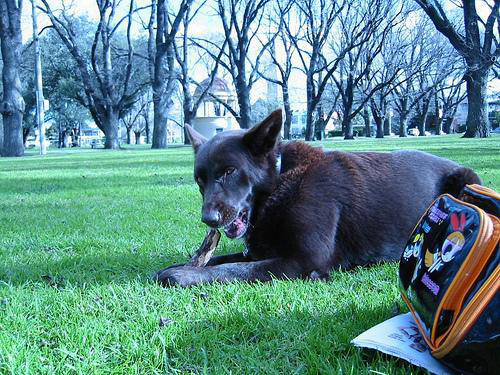

In [3]:
files = os.listdir(data_train_path)

from PIL import Image

pic = Image.open(data_train_path + files[3])

pic

In [4]:
import torchvision
import matplotlib.pyplot as plt

In [5]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class DogDataset(Dataset):
    def __init__(self, csv_labels, root_dir, transform = None):
        self.dog_frame = pd.read_csv(csv_labels)
        self.root_dir = root_dir
        self.transform = transform
        
        
        self.labels = self.dog_frame['breed'].unique()
        self.label_indexes = {}
        for i, label in enumerate(self.labels):
            self.label_indexes[label] = i
            
    def __len__(self):
        return len(self.dog_frame)
    
    def __getitem__(self, idx):
        
        image_path = self.root_dir + self.dog_frame.iloc[idx, 0] + '.jpg'
        image = Image.open(image_path)
        image = image.resize((PIC_SIZE, PIC_SIZE), Image.ANTIALIAS)
        
        label_str = self.dog_frame.iloc[idx, 1]
        label = self.label_indexes[label_str]
        
        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': label}
        return [image, label]
        

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader


normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Scale(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])

dataset = DogDataset(data_labels_path, data_train_path, transform=ds_trans)


indicies = np.arange(len(dataset))


# Разбиение датасета на train и validation
train_sampler = SubsetRandomSampler(indicies[:int(len(dataset)*0.5)])
validation_sampler = SubsetRandomSampler(indicies[int(len(dataset)*0.5):])


# DataLoader достаёт данные из dataset батчами
device = "cuda"
batch_size = 16
num_workers = 8
dogTrainLoader = DataLoader(dataset, batch_size=batch_size, shuffle=False, sampler=train_sampler,
                          num_workers=num_workers,
                          drop_last=True, pin_memory="cuda" in device)
dogValidationLoader = DataLoader(dataset, batch_size=2*batch_size, shuffle=False, sampler=validation_sampler,
                        num_workers=num_workers,
                        drop_last=False, pin_memory="cuda" in device)


/opt/conda/lib/python3.6/site-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


tensor(42) australian_terrier


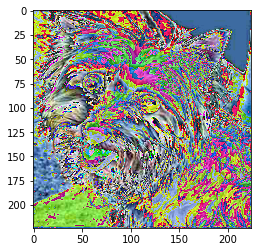

In [7]:

ToPIL = transforms.ToPILImage()


img, label  = next(iter(dogTrainLoader))
#print(batch[1], dataset.labels[batch[0]])
print(label[1], dataset.labels[label[1]] )
plt.imshow(ToPIL(img[1]))

In [8]:
!pip install pytorch-ignite

In [9]:
import torch.nn as nn
from torchvision import  models

model = models.resnext101_32x8d(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

#model.fc = torch.nn.Linear(model.fc.in_features, 2)
fc_inputs =  model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 120),
   #torch.nn.ReLU(),
    #torch.nn.Dropout(0.4),
    #torch.nn.Linear(100, 2), 
   #nn.LogSoftmax(dim=1) # For using NLLLoss()
)


model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /tmp/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:07<00:00, 48.2MB/s]


In [10]:
import torch.nn as nn
from torch.optim import SGD

optimizer = SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [11]:
from ignite.engine import Engine, _prepare_batch

def process_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = _prepare_batch(batch, device=device)
    #x, y = batch['image'], batch['label']
    #x, y = x.to(device), y.to(device)
    #print(x[0])
    #x = convert_tensor(x, device=device)
    #y = convert_tensor(x, device=device)
    
    #print(x[0])
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(process_function)

In [12]:
from ignite.engine import Events

log_interval = 50

@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iteration = (engine.state.iteration - 1) % len(dogTrainLoader) + 1
    if iteration % log_interval == 0:
        print("Epoch[{}] Iteration[{}/{}] Loss: {:.4f}"
              .format(engine.state.epoch, 
                         iteration, 
                         len(dogTrainLoader), 
                         engine.state.output))

In [13]:
#output = trainer.run(dogTrainLoader, max_epochs=1)

In [14]:
from ignite.metrics import Loss, Precision, Recall, Accuracy



metrics = {
    'avg_loss': Loss(criterion),
    'avg_accuracy': Accuracy(),
    'avg_precision': Precision(average=True),
    'avg_recall': Recall(average=True)
}

In [15]:
from ignite.engine import create_supervised_evaluator



train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [16]:
from torch.utils.data.dataset import Subset

indices = np.arange(len(dataset))
random_indices = np.random.permutation(indices)[:len(dataset)]
train_subset = Subset(dataset, indices=random_indices)

train_eval_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                                num_workers=num_workers, 
                                drop_last=True, pin_memory="cuda" in device)

In [17]:
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_offline_train_metrics(engine):
    epoch = engine.state.epoch
    print("Compute train metrics...")
    metrics = train_evaluator.run(train_eval_loader).metrics
    print("Training Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}"
          .format(engine.state.epoch, 
                      metrics['avg_loss'], 
                      metrics['avg_accuracy'], 
                      metrics['avg_precision'], 
                      metrics['avg_recall']))

@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_val_metrics(engine):
    epoch = engine.state.epoch
    print("Compute validation metrics...")
    metrics = val_evaluator.run(dogValidationLoader).metrics
    print("Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}"
          .format(engine.state.epoch, 
                      metrics['avg_loss'], 
                      metrics['avg_accuracy'], 
                      metrics['avg_precision'], 
                      metrics['avg_recall']))

In [18]:
#output = trainer.run(dogTrainLoader, max_epochs=1)

In [19]:
!pip install git+https://github.com/pytorch/ignite

  Cloning https://github.com/pytorch/ignite to /tmp/pip-req-build-ku8c3k27
  Running command git clone -q https://github.com/pytorch/ignite /tmp/pip-req-build-ku8c3k27
  Created wheel for pytorch-ignite: filename=pytorch_ignite-0.2.0-py2.py3-none-any.whl size=82052 sha256=5d9df7d42d0905dc9d0dfbdfad2910b5735f126798e0398a06f83004761cc2d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-rj0kck0x/wheels/92/9a/cd/39c0bc302c48329ecbe3a0d8b56678725a25332c7e9100d3b5
Successfully built pytorch-ignite


In [20]:
from torch.optim.lr_scheduler import ExponentialLR

lr_scheduler = ExponentialLR(optimizer, gamma=0.9)

@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Вывод значений скорости обучения:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
        print("Learning rate: {}".format(lr))
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])
            print("Learning rate (group {}): {}".format(i, lr))

In [21]:
from ignite.handlers import ModelCheckpoint

def score_function(engine):
    val_avg_accuracy = engine.state.metrics['avg_accuracy']
    return val_avg_accuracy

best_model_saver = ModelCheckpoint("best_models",  
                                   filename_prefix="model",
                                   score_name="val_accuracy",  
                                   score_function=score_function,
                                   n_saved=3,
                                   save_as_state_dict=True,
                                   create_dir=True)


val_evaluator.add_event_handler(Events.COMPLETED, 
                                best_model_saver, 
                                {"best_model": model})

In [22]:
training_saver = ModelCheckpoint("checkpoint",
                             filename_prefix="checkpoint",
                             save_interval=1000,
                             n_saved=1,
                             save_as_state_dict=True,
                             create_dir=True)

to_save = {"model": model, "optimizer": optimizer, "lr_scheduler": lr_scheduler} 
trainer.add_event_handler(Events.ITERATION_COMPLETED, training_saver, to_save)

In [23]:
from ignite.handlers import EarlyStopping

early_stopping = EarlyStopping(patience=10, 
                              score_function=score_function, 
                              trainer=trainer)

val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, early_stopping)

In [24]:
#max_epochs = 20
#output = trainer.run(dogTrainLoader, max_epochs=50)

In [25]:
#!ls best_models/

In [26]:
#!rm -R best_models/ checkpoint